In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize, curve_fit
from scipy.special import comb  # For binomial coefficients
import pandas as pd
from scipy.stats import qmc
from joblib import Parallel, delayed
import seaborn as sns

In [6]:
class Vasicek:
    def __init__(self, kappa, theta, sigma):
        """
        Initialize the parameters for the Vasicek model.
        
        :param kappa: Speed of mean reversion
        :param theta: Long-term mean level
        :param sigma: Volatility of the process
        """
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma

    def generate(self, X0, T, N, n):
        """
        Generate N trajectories of the Vasicek process on the interval [0, T] with a time step of T/n.
        
        :param X0: Initial value of the process
        :param T: The total time period
        :param N: Number of trajectories to generate
        :param n: Number of discretization steps (so time step is T/n)
        
        :return: Array of N trajectories discretized over the interval [0, T]
        """
        dt = T / n  # Adjusted time step for the interval [0, T]
        trajectories = np.zeros((N, n))  # Matrix to store the trajectories
        trajectories[:, 0] = X0  # Initialize all trajectories at X0

        for i in range(1, n):
            # Generate standard normal noise
            Z = np.random.randn(N)  # Standard normal random variables for each trajectory
            # Update the process value according to the Vasicek model
            trajectories[:, i] = (
                trajectories[:, i - 1] * np.exp(-self.kappa * dt)
                + self.theta * (1 - np.exp(-self.kappa * dt))
                +  np.sqrt((self.sigma**2) *(1 - np.exp(-2 * self.kappa * dt)) / (2 * self.kappa)) * Z
            )

        return trajectories


In [7]:
def calculate_sum(n, f, kappa=1, theta=1, sigma=0.5, X0=0.05,T=5000):
    """
    Calculate the summation: (1/n) * sum_{k=0}^n f(X_k), where X_k is generated by the Vasicek model.
    
    :param n: Number of steps in the discretization
    :param f: Function to apply to each X_k
    :param kappa: Speed of mean reversion
    :param theta: Long-term mean level
    :param sigma: Volatility
    :param X0: Initial value of the process
    :return: The computed summation
    """
    vasicek_process = Vasicek(kappa, theta, sigma)
      # Time horizon

    # Generate one trajectory
    trajectories = vasicek_process.generate(X0, T, 1, n)  # One trajectory, n steps
    res = 0
    trajectory = trajectories[0]  # Take the first trajectory
    res +=(1 / n) * sum(f(x) for x in trajectory)
    # Compute the summation
    return res


In [8]:
def expected_value_vasicek(power, theta, sigma, kappa):
    """
    Compute the expected value of the Vasicek process at X_n using the closed-form formula.
    
    :param n: Number of steps in the discretization
    :param theta: Long-term mean level
    :param sigma: Volatility
    :param kappa: Speed of mean reversion
    :return: The theoretical expected value
    """
    expected_sum = 0
    for k in range(power + 1):
        # Binomial coefficient
        binom_coeff = comb(power, k)
        
        # Factor for theta and sigma
        theta_factor = theta**(power - k)

        sigma_factor = sigma**k / (2 * kappa)**(k//2)
        
        # Expectation of Z^k
        if k % 2 == 0:  # Even powers of Z
            m = k // 2
            # For even k, the expectation of Z^{2m} is (2m-1)!! = (2m-1)*(2m-3)*...*1
            z_expectation = math.factorial(2 * m) // (2**m * math.factorial(m))  # Double factorial calculation
        else:  # Odd powers of Z
            z_expectation = 0
        
        # Add to the summation
        expected_sum += binom_coeff * theta_factor * sigma_factor * z_expectation
    
    return expected_sum

In [9]:
#define params
n_simulations = 10000
n = 252*20
T = 20
X0 = 0.1
# True parameters
kappa_true = 0.589  # Vitesse de retour à la moyenne
theta_true = 0.155  # Moyenne long-terme
sigma_true = 0.238  # Volatilité
true_theta = 0.155
true_sigma = 0.238
true_kappa = 0.589
# Générer les données
vasicek_process = Vasicek(true_kappa, true_theta, true_sigma)
X = vasicek_process.generate(X0, T, n_simulations, n)  # X est de taille (n_simulations, n)
trajectories = np.copy(X)
method = 'nelder-mead'


In [10]:
def empirical_value_vasicek(X, order):
    """Calcule la valeur empirique du moment d'ordre donné."""
    return np.mean(X**order)

def pure_moments_calibration(X, max_order, n_init=10):
    """Calibre les paramètres du modèle de Vasicek en minimisant l'erreur des moments purs."""

    # Moments empiriques
    orders = np.arange(1, max_order + 1)
    y_obs = np.array([empirical_value_vasicek(X, i) for i in orders])

    # Fonction coût vectorisée
    def cost(params):
        theta, sigma, kappa = params
        errors = np.array([expected_value_vasicek(i, theta, sigma, kappa) - y_obs[i-1] for i in orders])
        return np.sum(errors**2)

    # Initialisation
    sampler = qmc.LatinHypercube(d=3)
    initial_samples = qmc.scale(sampler.random(n_init), l_bounds=[0.01, 0.01, 0.01], u_bounds=[1, 1, 1])

    # Optimisation en parallèle
    def optimize_from_guess(guess):
        res = minimize(cost, guess, method=method, bounds=[(1e-7, 1), (1e-7, 1), (1e-7, 1)])
        return res.x, res.fun

    results = Parallel(n_jobs=-1)(delayed(optimize_from_guess)(guess) for guess in initial_samples)

    # Sélection de la meilleure solution
    best_params, best_cost = min(results, key=lambda x: x[1])

    return *best_params, best_cost

In [11]:

def empirical_moments(X, max_order):
    return np.array([np.mean(X**i) for i in range(1, max_order + 1)])

def compute_weight_matrix(X, theta, sigma, kappa, max_order):
    orders = np.arange(1, max_order + 1)
    n = X.shape[0]
    y_model = np.array([expected_value_vasicek(i, theta, sigma, kappa) for i in orders])
    errors = (X[:, None] ** orders[None, :]) - y_model
    S = np.cov(errors, rowvar=False)
    epsilon = 1e-6
    S += epsilon * np.eye(S.shape[0])
    W = np.linalg.inv(S)
    return W

def pure_moments_calibration_2step(X, max_order, n_init=10):
    """Calibration by Pure Moments using 2-Step GMM."""
    orders = np.arange(1, max_order + 1)
    y_obs = empirical_moments(X, max_order)
    W = np.eye(max_order)  # Initial weight matrix

    def cost(params):
        theta, sigma, kappa = params
        y_model = np.array([expected_value_vasicek(i, theta, sigma, kappa) for i in orders])
        errors = y_model - y_obs
        return errors @ W @ errors

    sampler = qmc.LatinHypercube(d=3)
    initial_samples = qmc.scale(sampler.random(n_init), l_bounds=[0.01, 0.01, 0.01], u_bounds=[1, 1, 1])

    def optimize_from_guess(guess, cost_fn):
        res = minimize(cost_fn, guess, method=method, bounds=[(1e-7, 1)] * 3)
        return res.x, res.fun

    # Step 1
    results = Parallel(n_jobs=-1)(delayed(optimize_from_guess)(guess, cost) for guess in initial_samples)
    best_params, _ = min(results, key=lambda x: x[1])
    theta_1, sigma_1, kappa_1 = best_params

    # Step 2: update weight matrix and re-minimize with new cost
    W = compute_weight_matrix(X, theta_1, sigma_1, kappa_1, max_order)

    def cost_step2(params):
        theta, sigma, kappa = params
        y_model = np.array([expected_value_vasicek(i, theta, sigma, kappa) for i in orders])
        errors = y_model - y_obs
        return errors @ W @ errors

    results2 = Parallel(n_jobs=-1)(delayed(optimize_from_guess)(guess, cost_step2) for guess in initial_samples)
    best_params2, best_cost = min(results2, key=lambda x: x[1])
    theta2, sigma2, kappa2 = best_params2

    return theta2, sigma2, kappa2, best_cost



In [12]:

def moment_estimators(X, T):
    h = T / len(X)
    n = len(X) - 2  
    mean_X = np.mean(X)
    sum_X = np.sum(X[:-1]) / n
    sum_X_X1 = np.sum(X[:-1] * X[1:]) / n
    sum_X_X2 = np.sum(X[:-2] * X[2:]) / n
    
    numerator = (sum_X ** 2 - sum_X_X1)
    denominator = (sum_X ** 2 - sum_X_X2)
    
    kappa_hat = (1 / h) * np.log(numerator / denominator)
    sigma2_hat = -2 * kappa_hat * (numerator ** 2) / denominator  
    theta_hat = mean_X
    
    return theta_hat, sigma2_hat, kappa_hat


In [13]:
# Theoretical covariance function
def theoretical_covariance(h, kappa, sigma):
    return (sigma**2 / (2 * kappa)) * np.exp(-kappa * h)

# Empirical covariance function
def empirical_covariance(X, n, T, theta_emp, h):
    k0 = int(n * h / T)  # Convert lag h to index
    cov = 0
    for k in range(n - k0):
        cov += (X[k] * X[k + k0]) / (n - k0)
    return cov - theta_emp**2

# Function to estimate kappa and sigma using minimization
def estimate_kappa_sigma(X, n, T, theta_emp, lags):
    # Compute empirical covariance for the given lags
    covariances = np.array([empirical_covariance(X, n, T, theta_emp, h) for h in lags])

    # Loss function to minimize
    def loss(params):
        kappa, sigma = params
        return np.sum((covariances - theoretical_covariance(lags, kappa, sigma)) ** 2)

    # Use multiple random initializations
    def optimize_from_guess(guess):
        res = minimize(loss, guess, method=method, bounds=[(1e-7, 1), (1e-7, 1)])
        return res.x, res.fun

    # Latin Hypercube Sampling for initial guesses
    sampler = qmc.LatinHypercube(d=2)
    n_init = 20
    initial_samples = qmc.scale(sampler.random(n_init), l_bounds=[0.01, 0.01], u_bounds=[1, 1])

    # Parallel optimization
    results = Parallel(n_jobs=-1)(delayed(optimize_from_guess)(guess) for guess in initial_samples)
    best_params, best_cost = min(results, key=lambda x: x[1])

    return best_params[0], best_params[1]

In [14]:
def covariance_2step(X, n, T, theta_emp, lags):
    empirical_covs = np.array([empirical_covariance(X, n, T, theta_emp, h) for h in lags])

    # === STEP 1: initial estimation via least squares ===
    def loss_step1(params):
        kappa, sigma = params
        model_covs = theoretical_covariance(lags, kappa, sigma)
        return np.sum((empirical_covs - model_covs) ** 2)

    bounds = [(1e-6, 1), (1e-6, 1)]

    # Latin Hypercube Sampling for step 1
    sampler = qmc.LatinHypercube(d=2)
    n_init = 10
    initial_samples = qmc.scale(
        sampler.random(n_init),
        l_bounds=[0.01, 0.01],
        u_bounds=[1.0, 1.0]
    )

    best_loss1 = float('inf')
    best_params1 = None

    for guess in initial_samples:
        res = minimize(loss_step1, guess, method=method, bounds=bounds)
        if res.fun < best_loss1:
            best_loss1 = res.fun
            best_params1 = res.x

    kappa_init, sigma_init = best_params1

    # === STEP 2: optimal weighting (single estimation from step 1 result) ===
    theoretical_covs_init = theoretical_covariance(lags, kappa_init, sigma_init)
    residuals = empirical_covs - theoretical_covs_init

    S = np.outer(residuals, residuals)
    S += 1e-6 * np.eye(len(lags))  # Regularization
    try:
        W = np.linalg.inv(S)
    except np.linalg.LinAlgError:
        W = np.eye(len(lags))

    def loss_step2(params):
        kappa, sigma = params
        model_covs = theoretical_covariance(lags, kappa, sigma)
        diff = empirical_covs - model_covs
        return diff @ W @ diff

    #res2 = minimize(loss_step2, best_params1, method=method, bounds=bounds)
    kappa_final, sigma_final = None, None
    best_loss = float('inf')
    for guess in initial_samples:
        res = minimize(loss_step2, guess, method=method, bounds=bounds)
        if res.fun < best_loss:
            best_loss = res.fun
            kappa_final, sigma_final = res.x
    return kappa_final, sigma_final


In [15]:
def estimate_parameters_mle(trajectory , T = T):
    n = len(trajectory)
    delta_t = T / n
    Rt = np.array(trajectory)
    
    # Calculate terms
    Rt_shifted = Rt[:-1]  # R_{t_{i-1}}
    Rt_current = Rt[1:]  # R_{t_i}
    
    #  (kappa)
    mean_RtRt_shifted = np.mean(Rt_current * Rt_shifted)
    mean_Rt = np.mean(Rt_current)
    mean_Rt_shifted = np.mean(Rt_shifted)
    mean_Rt_shifted_squared = np.mean(Rt_shifted ** 2)
    
    numerator_alpha = mean_RtRt_shifted - mean_Rt * mean_Rt_shifted
    denominator_alpha = mean_Rt_shifted_squared - mean_Rt_shifted ** 2
    kappa = -1 / delta_t * np.log(numerator_alpha / denominator_alpha)
    
    #  (theta)
    numerator_theta = np.sum(Rt_current) - np.exp(kappa * delta_t) * np.sum(Rt_shifted)
    denominator_theta = n * (1 - np.exp(-kappa * delta_t))
    theta = numerator_theta / denominator_theta
    
    # sigma^2
    term1 = Rt_current - Rt_shifted * np.exp(-kappa * delta_t)
    term2 = theta * (1 - np.exp(-kappa * delta_t))
    sigma_squared = (2 * kappa) / (n * (1 - np.exp(-2 * kappa * delta_t))) * np.sum((term1 - term2) ** 2)
    
    return kappa, abs(theta), np.sqrt(sigma_squared)

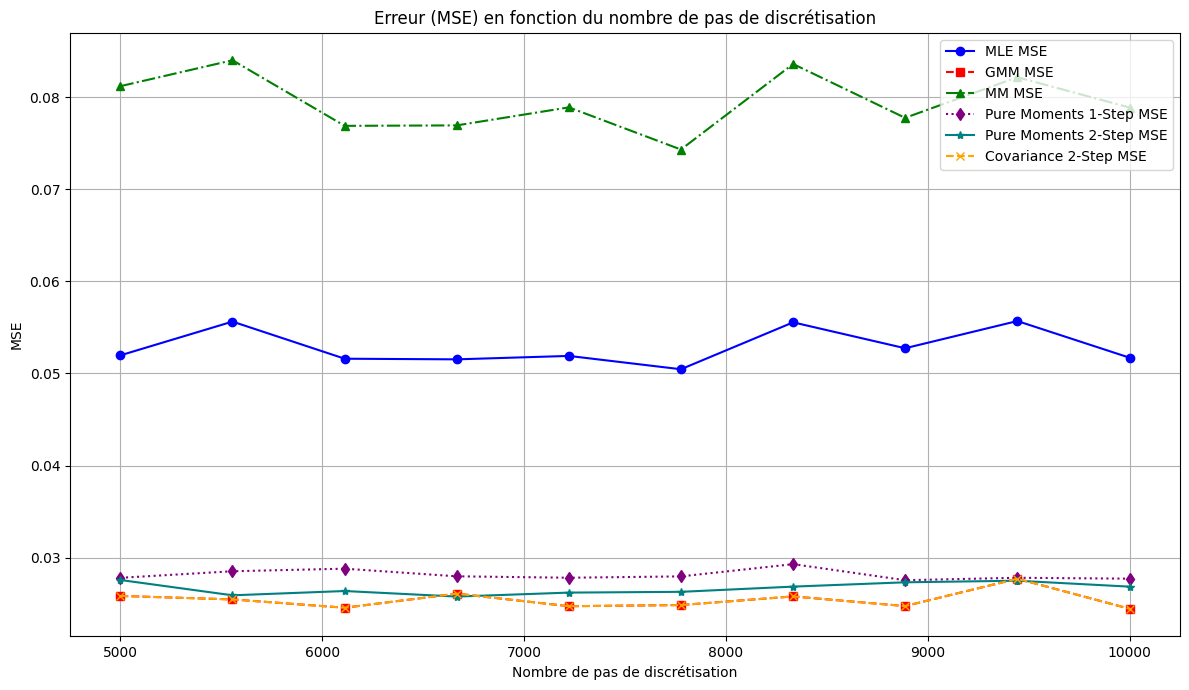

/tmp/ipykernel_97527/336831268.py:120: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([error], labels=[label], patch_artist=True)


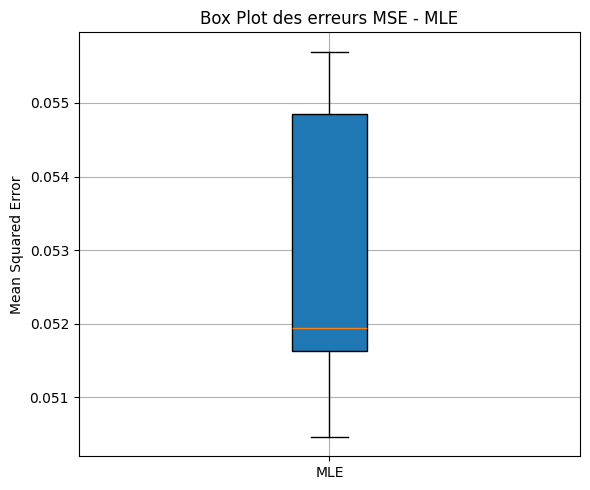

/tmp/ipykernel_97527/336831268.py:120: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([error], labels=[label], patch_artist=True)


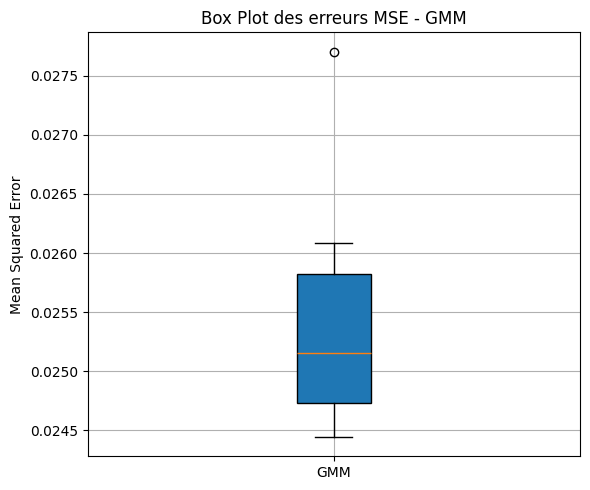

/tmp/ipykernel_97527/336831268.py:120: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([error], labels=[label], patch_artist=True)


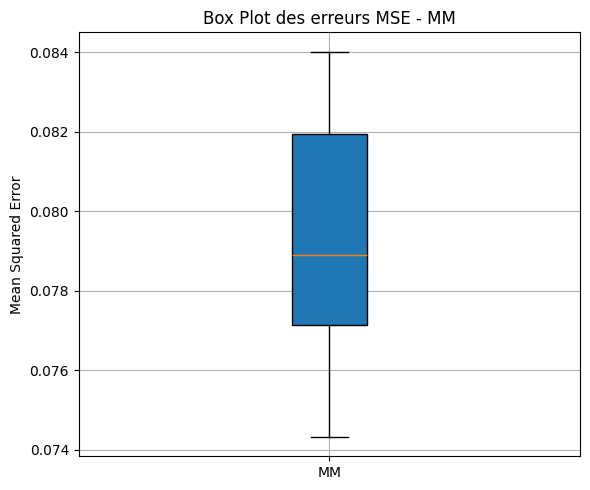

/tmp/ipykernel_97527/336831268.py:120: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([error], labels=[label], patch_artist=True)


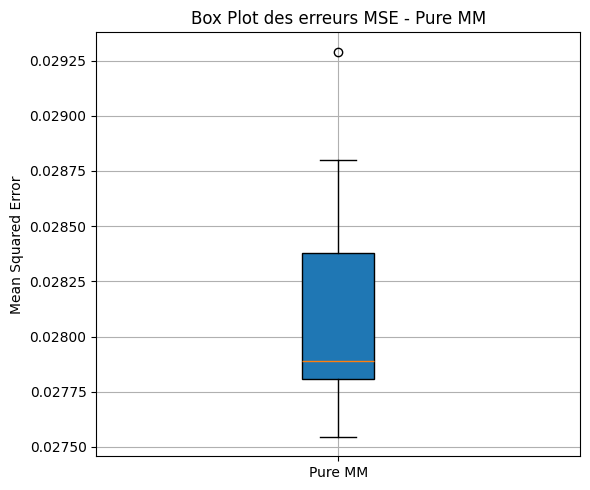

/tmp/ipykernel_97527/336831268.py:120: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([error], labels=[label], patch_artist=True)


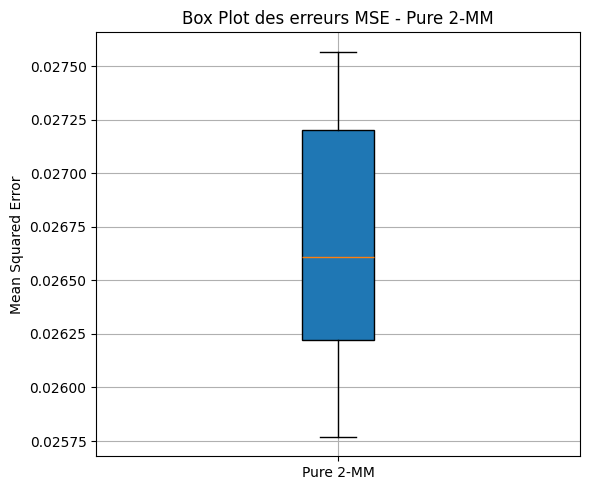

/tmp/ipykernel_97527/336831268.py:120: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([error], labels=[label], patch_artist=True)


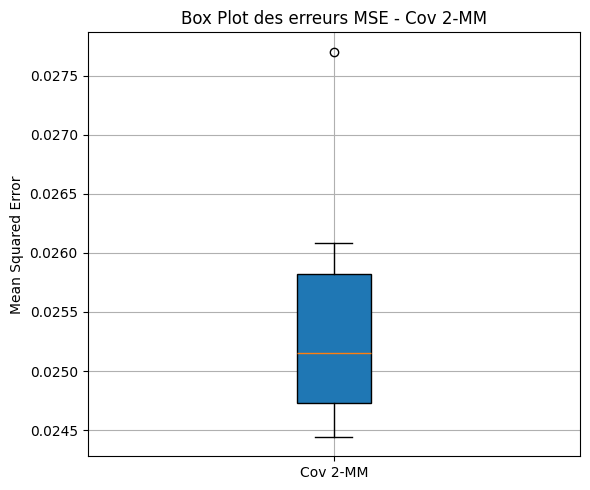

In [16]:
def MSE(params,true_params):
    return np.mean((params - true_params) ** 2)
n_range = np.linspace(250*20, 500*20, 10, dtype=int)  # n entre 5000 et 10000
T = 20
X0 = 0.05
N = 1000  # nombre de trajectoires dans generate

num_lags = 10
max_order = 6
n_trials = N  # Nombre de trajectoires par valeur de n

MLE_error = []
GMM_error = []
MM_error = []
pure_MM_error = []
pure_2_MM_error = []
cov_2_MM_error = []
def process_trajectory(trajectory, n, T, kappa_true, theta_true, sigma_true, max_order, num_lags):
    theta_emp = np.mean(trajectory)
    lags = np.array([i * T / n for i in range(num_lags)])

    # MLE
    kappa_MLE, theta_MLE, sigma_MLE = estimate_parameters_mle(trajectory, T)
    mse_MLE = MSE(np.array([kappa_MLE, theta_MLE, sigma_MLE]), np.array([kappa_true, theta_true, sigma_true]))

    # GMM (cov simple)
    kappa_GMM, sigma_GMM = estimate_kappa_sigma(trajectory, n, T, theta_emp, lags)
    mse_GMM = MSE(np.array([kappa_GMM, theta_emp, sigma_GMM]), np.array([kappa_true, theta_true, sigma_true]))

    # MM (moment formulas)
    theta_MM, sigma2_MM, kappa_MM = moment_estimators(trajectory, T)
    mse_MM = MSE(np.array([kappa_MM, theta_MM, sigma2_MM]), np.array([kappa_true, theta_true, sigma_true]))

    # Pure Moments 1-Step
    theta_PM1, sigma2_PM1, kappa_PM1, _ = pure_moments_calibration(trajectory, max_order)
    mse_PM1 = MSE(np.array([kappa_PM1, theta_PM1, sigma2_PM1]), np.array([kappa_true, theta_true, sigma_true]))

    # Pure Moments 2-Step
    theta_PM2, sigma2_PM2, kappa_PM2, _ = pure_moments_calibration_2step(trajectory, max_order)
    mse_PM2 = MSE(np.array([kappa_PM2, theta_PM2, sigma2_PM2]), np.array([kappa_true, theta_true, sigma_true]))

    # Covariance 2-Step
    kappa_COV2, sigma_COV2 = covariance_2step(trajectory, n, T, theta_emp, lags)
    mse_COV2 = MSE(np.array([kappa_COV2, theta_emp, sigma_COV2]), np.array([kappa_true, theta_true, sigma_true]))

    return mse_MLE, mse_GMM, mse_MM, mse_PM1, mse_PM2, mse_COV2
for n in n_range:
    mse_mle_sum = 0
    mse_gmm_sum = 0
    mse_mm_sum = 0
    mse_pm1_sum = 0
    mse_pm2_sum = 0
    mse_cov2_sum = 0

    for _ in range(n_trials):
        vasicek_process = Vasicek(kappa_true, theta_true, sigma_true)
        trajectory = vasicek_process.generate(X0, T, N=1, n=n)[0]  # Une seule trajectoire

        mse_MLE, mse_GMM, mse_MM, mse_PM1, mse_PM2, mse_COV2 = process_trajectory(
            trajectory, n, T, kappa_true, theta_true, sigma_true, max_order, num_lags
        )

        mse_mle_sum += mse_MLE
        mse_gmm_sum += mse_GMM
        mse_mm_sum += mse_MM
        mse_pm1_sum += mse_PM1
        mse_pm2_sum += mse_PM2
        mse_cov2_sum += mse_COV2

    MLE_error.append(mse_mle_sum / n_trials)
    GMM_error.append(mse_gmm_sum / n_trials)
    MM_error.append(mse_mm_sum / n_trials)
    pure_MM_error.append(mse_pm1_sum / n_trials)
    pure_2_MM_error.append(mse_pm2_sum / n_trials)
    cov_2_MM_error.append(mse_cov2_sum / n_trials)
def plot_errors(n_range, MLE_error, GMM_error, MM_error, pure_MM_error, pure_2_MM_error, cov_2_MM_error):
    fig, ax = plt.subplots(figsize=(12, 7))

    ax.plot(n_range, MLE_error, label='MLE MSE', marker='o', color='b')
    ax.plot(n_range, GMM_error, label='GMM MSE', marker='s', linestyle='dashed', color='r')
    ax.plot(n_range, MM_error, label='MM MSE', marker='^', linestyle='-.', color='g')
    ax.plot(n_range, pure_MM_error, label='Pure Moments 1-Step MSE', marker='d', linestyle=':', color='purple')
    ax.plot(n_range, pure_2_MM_error, label='Pure Moments 2-Step MSE', marker='*', linestyle='-', color='teal')
    ax.plot(n_range, cov_2_MM_error, label='Covariance 2-Step MSE', marker='x', linestyle='--', color='orange')

    ax.set_xlabel('Nombre de pas de discrétisation')
    ax.set_ylabel('MSE')
    ax.set_title('Erreur (MSE) en fonction du nombre de pas de discrétisation')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()
# === Affichage final ===
plot_errors(n_range, MLE_error, GMM_error, MM_error, pure_MM_error, pure_2_MM_error, cov_2_MM_error)

# Assure que les erreurs sont bien des vecteurs 1D
MLE_error = np.array(MLE_error).flatten()
GMM_error = np.array(GMM_error).flatten()
MM_error = np.array(MM_error).flatten()
pure_MM_error = np.array(pure_MM_error).flatten()
pure_2_MM_error = np.array(pure_2_MM_error).flatten()
cov_2_MM_error = np.array(cov_2_MM_error).flatten()

# Toutes les erreurs et leurs étiquettes
all_errors = [
    MLE_error,
    GMM_error,
    MM_error,
    pure_MM_error,
    pure_2_MM_error,
    cov_2_MM_error
]

labels = ["MLE", "GMM", "MM", "Pure MM", "Pure 2-MM", "Cov 2-MM"]

# Afficher un box plot par méthode
for error, label in zip(all_errors, labels):
    plt.figure(figsize=(6, 5))
    plt.boxplot([error], labels=[label], patch_artist=True)
    plt.title(f"Box Plot des erreurs MSE - {label}")
    plt.ylabel("Mean Squared Error")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


3


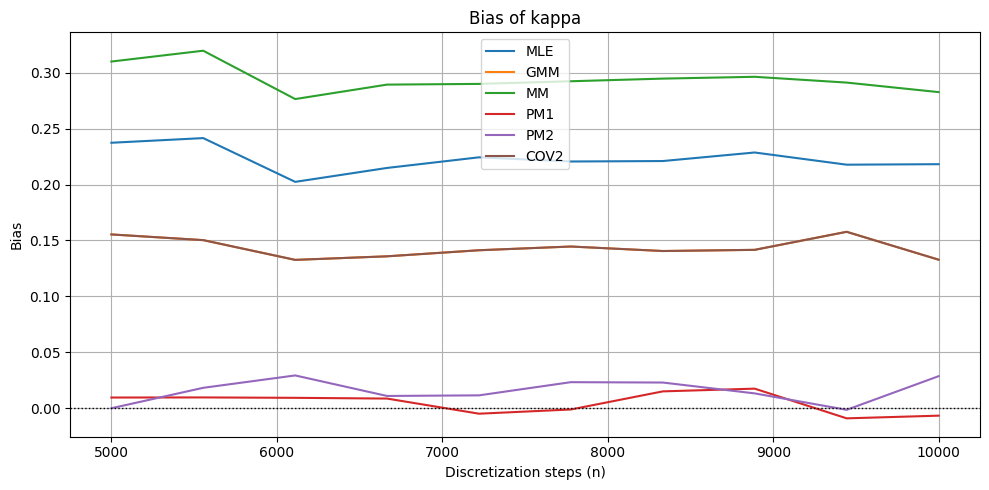

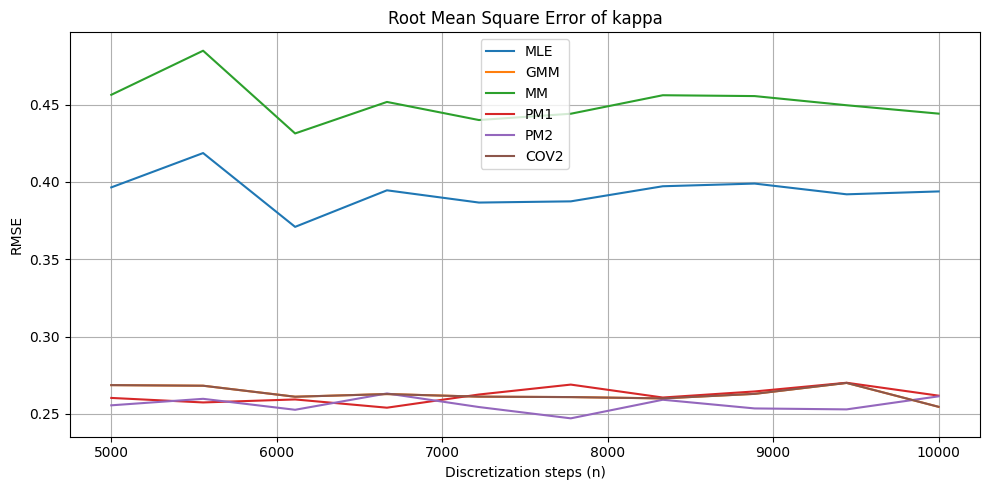

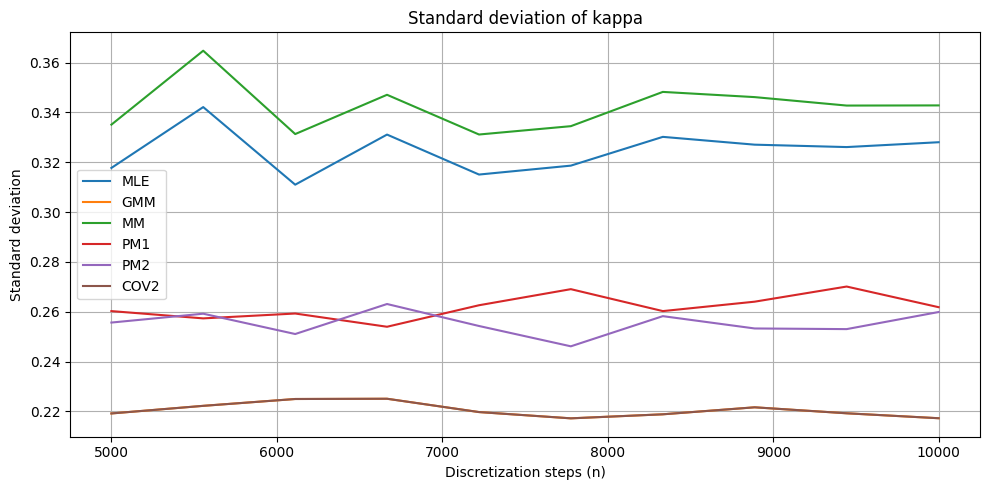

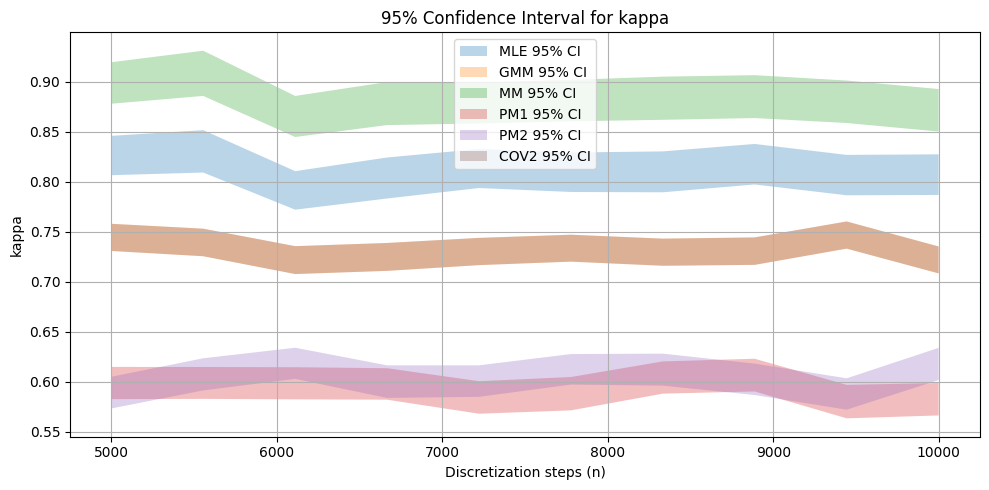

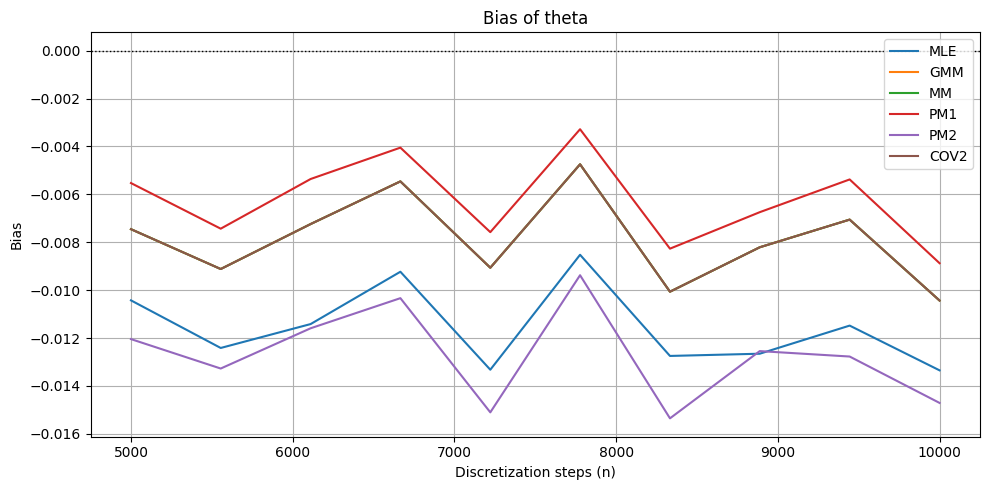

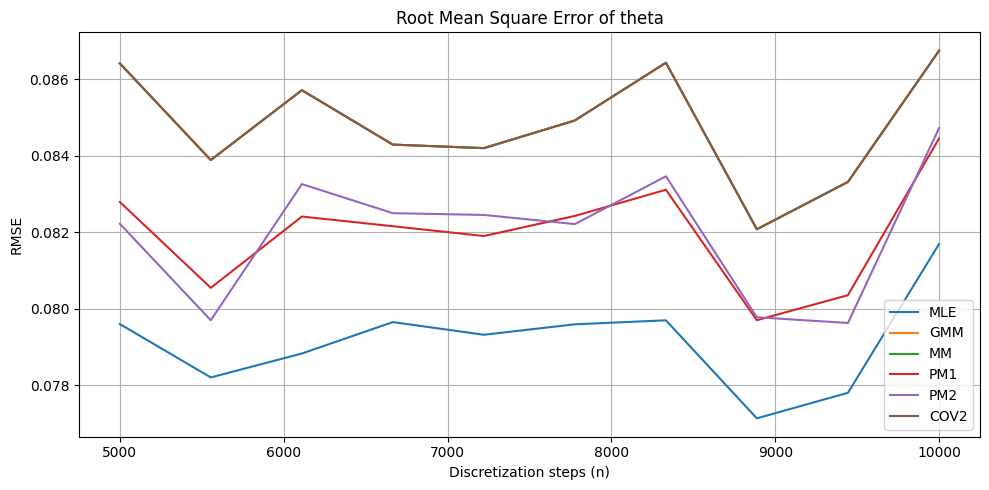

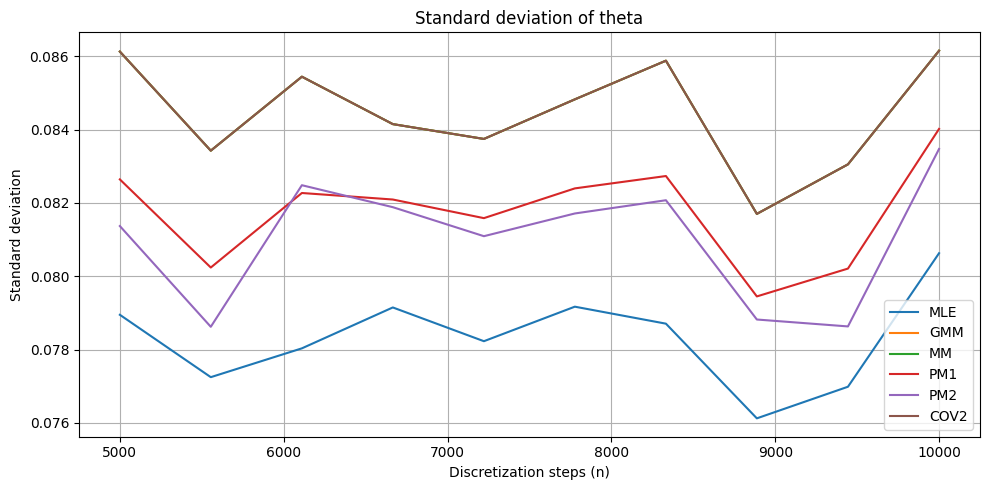

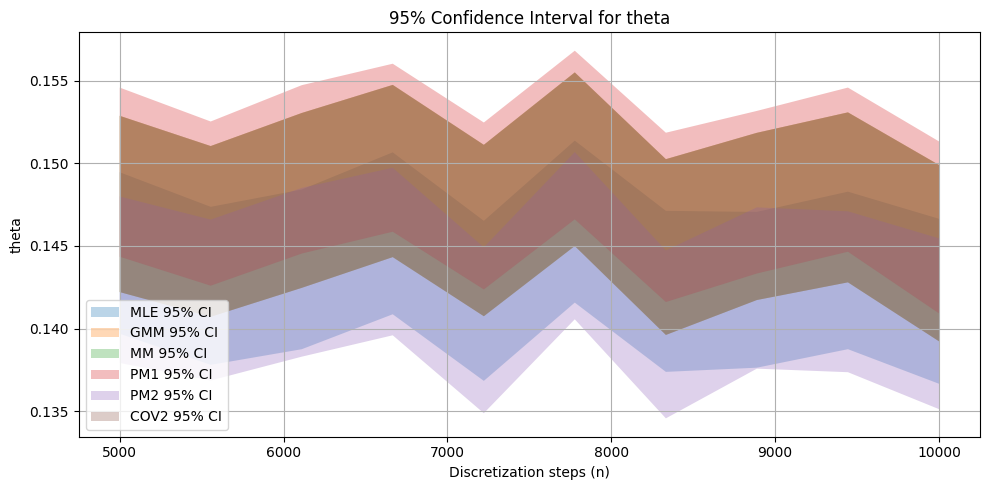

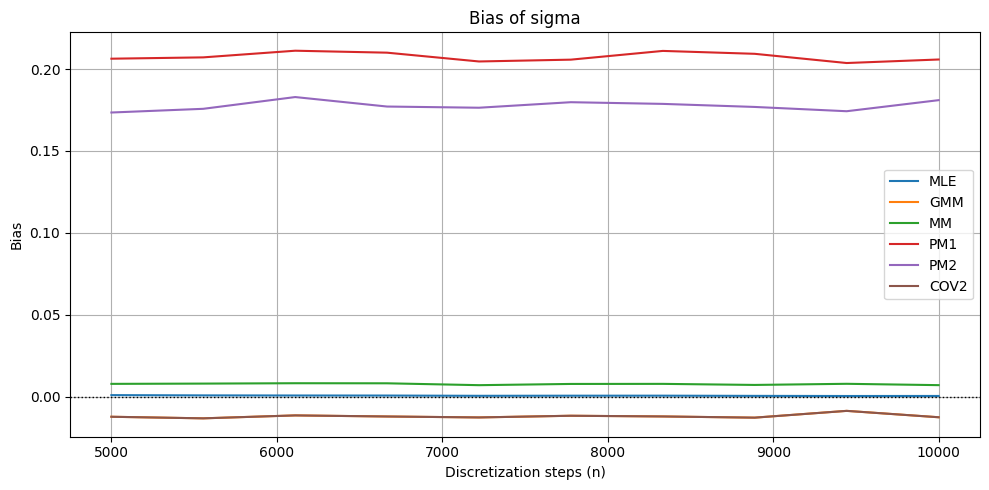

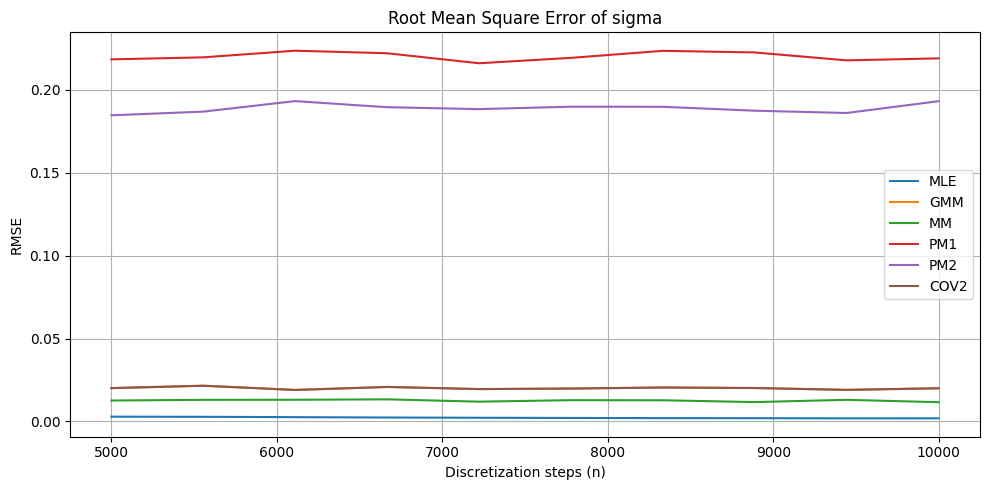

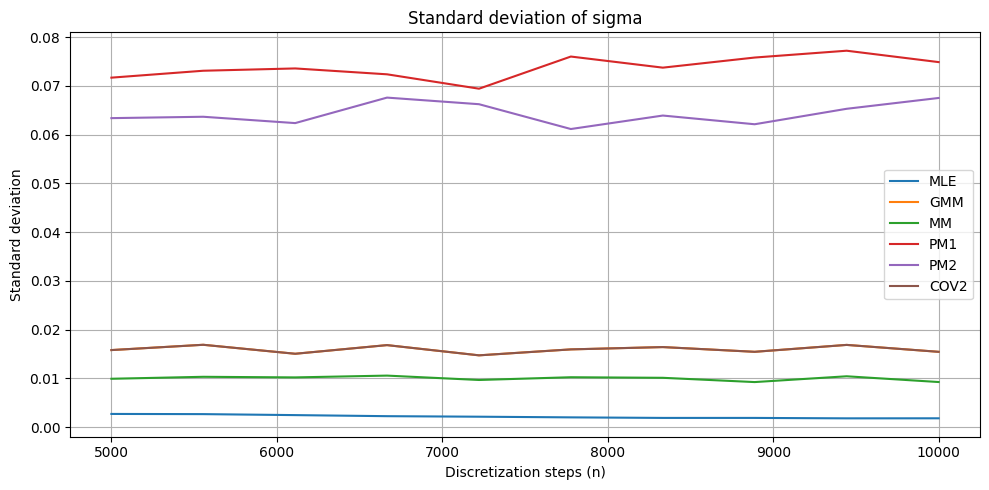

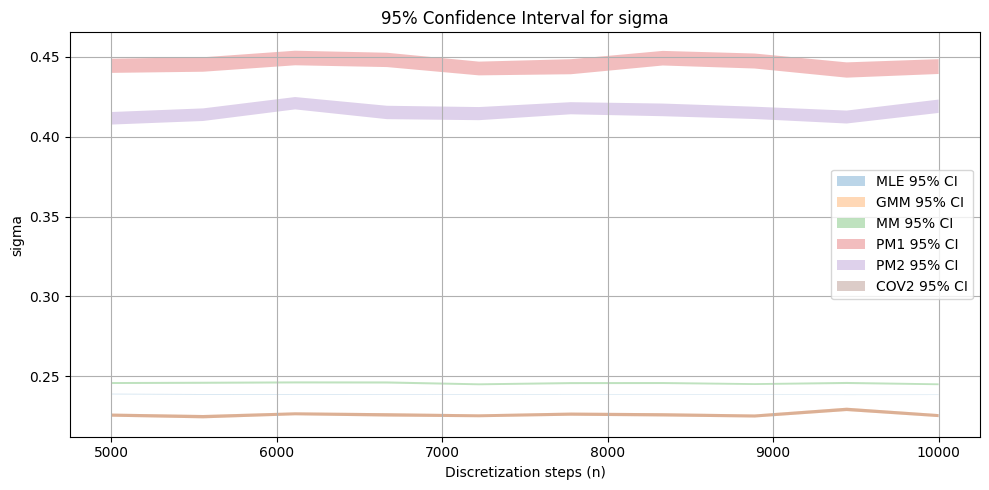

/tmp/ipykernel_97527/156077163.py:141: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=methods, showfliers=False)


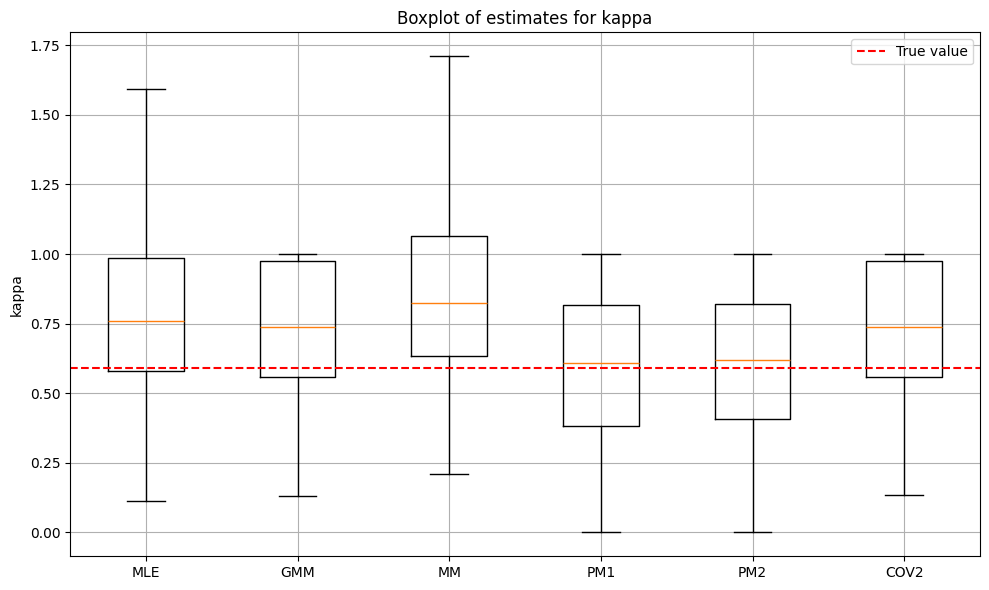

/tmp/ipykernel_97527/156077163.py:141: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=methods, showfliers=False)


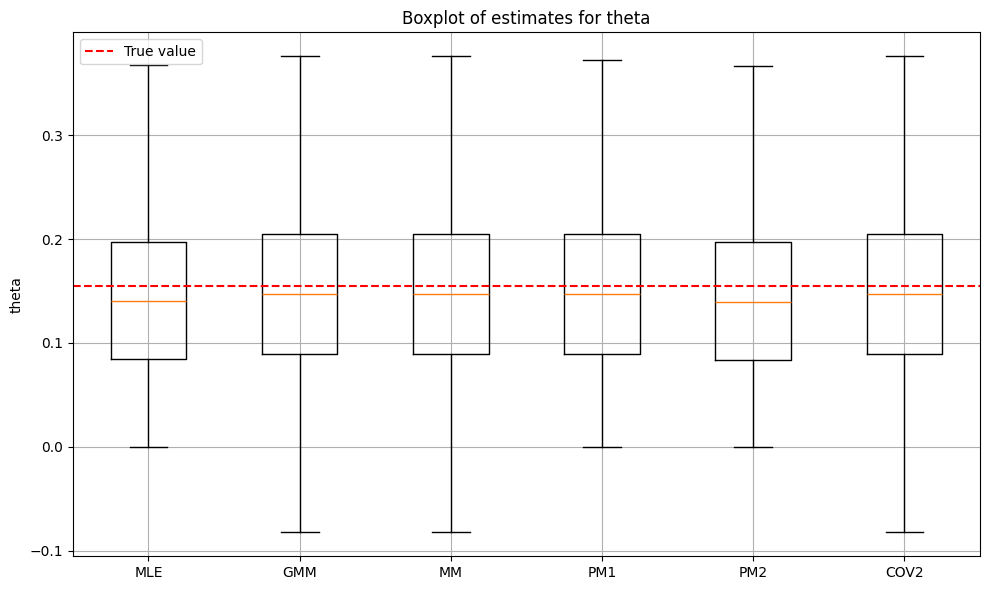

/tmp/ipykernel_97527/156077163.py:141: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=methods, showfliers=False)


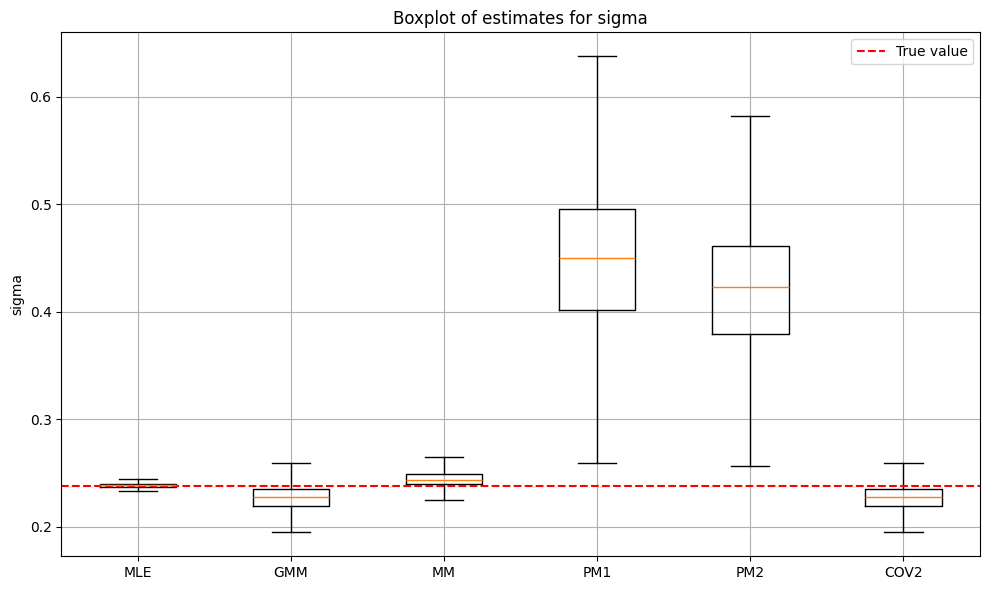

In [17]:
repeats = 1000
def process_simulation(trajectory, n, T, kappa_true, theta_true, sigma_true, max_order, num_lags):
    theta_emp = np.mean(trajectory)
    lags = np.array([i * T / n for i in range(num_lags)])

    # MLE
    kappa_MLE, theta_MLE, sigma_MLE = estimate_parameters_mle(trajectory, T)

    # GMM
    kappa_GMM, sigma_GMM = estimate_kappa_sigma(trajectory, n, T, theta_emp, lags)

    # MM
    theta_MM, sigma2_MM, kappa_MM = moment_estimators(trajectory, T)
    sigma_MM = np.sqrt(sigma2_MM)

    # PM1
    theta_PM1, sigma2_PM1, kappa_PM1, _ = pure_moments_calibration(trajectory, max_order)
    sigma_PM1 = np.sqrt(sigma2_PM1)

    # PM2
    theta_PM2, sigma2_PM2, kappa_PM2, _ = pure_moments_calibration_2step(trajectory, max_order)
    sigma_PM2 = np.sqrt(sigma2_PM2)

    # COV2
    kappa_COV2, sigma_COV2 = covariance_2step(trajectory, n, T, theta_emp, lags)

    return {
        "MLE": (kappa_MLE, theta_MLE, sigma_MLE),
        "GMM": (kappa_GMM, theta_emp, sigma_GMM),
        "MM": (kappa_MM, theta_MM, sigma_MM),
        "PM1": (kappa_PM1, theta_PM1, sigma_PM1),
        "PM2": (kappa_PM2, theta_PM2, sigma_PM2),
        "COV2": (kappa_COV2, theta_emp, sigma_COV2),
    }
methods = ["MLE", "GMM", "MM", "PM1", "PM2", "COV2"]
params = ["kappa", "theta", "sigma"]

estimates = {m: {p: [] for p in params} for m in methods}
true_vals = {"kappa": kappa_true, "theta": theta_true, "sigma": sigma_true}
T = 20
n = 252*20
num_lags = 10
max_order = 10
all_estimates_raw = {m: {p: [] for p in params} for m in methods}

for n in n_range:

    estimates_n = {m: {p: [] for p in params} for m in methods}


    for _ in range(repeats):
        vasicek_process = Vasicek(kappa_true, theta_true, sigma_true)
        trajectory = vasicek_process.generate(X0, T, 1, n)[0]

        results = process_simulation(trajectory, n, T, kappa_true, theta_true, sigma_true, max_order, num_lags)

        for m in methods:
            kappa, theta, sigma = results[m]
            estimates_n[m]["kappa"].append(kappa)
            estimates_n[m]["theta"].append(theta)
            estimates_n[m]["sigma"].append(sigma)
            all_estimates_raw[m]["kappa"].append(kappa)
            all_estimates_raw[m]["theta"].append(theta)
            all_estimates_raw[m]["sigma"].append(sigma)

    # Store aggregated stats
    for m in methods:
        for p in params:
            vals = np.array(estimates_n[m][p])
            mean = vals.mean()
            std = vals.std(ddof=1)
            bias = mean - true_vals[p]
            rmse = np.sqrt(np.mean((vals - true_vals[p])**2))

            ci_lo = mean - 1.96 * std / np.sqrt(repeats)
            ci_hi = mean + 1.96 * std / np.sqrt(repeats)

            estimates[m][p].append((bias, std, ci_lo, ci_hi,rmse))
print(len(params))
for p in params:
    # --- BIAIS ---
    plt.figure(figsize=(10, 5))
    for m in methods:
        bias_vals = [x[0] for x in estimates[m][p]]
        plt.plot(n_range, bias_vals, label=m)
        
    plt.axhline(0, color='black', linestyle=':', linewidth=1)
    plt.xlabel("Discretization steps (n)")
    plt.ylabel("Bias")
    plt.title(f"Bias of {p}")
    plt.grid(True)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    ## RMSE
    plt.figure(figsize=(10, 5))
    for m in methods:
        rmse_vals = [x[4] for x in estimates[m][p]]  # 5th element is RMSE
        plt.plot(n_range, rmse_vals, label=m)
    plt.xlabel("Discretization steps (n)")
    plt.ylabel("RMSE")
    plt.title(f"Root Mean Square Error of {p}")
    plt.grid(True)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    # --- ECART-TYPE ---
    plt.figure(figsize=(10, 5))
    for m in methods:
        std_vals = [x[1] for x in estimates[m][p]]
        plt.plot(n_range, std_vals, label=m)
    plt.xlabel("Discretization steps (n)")
    plt.ylabel("Standard deviation")
    plt.title(f"Standard deviation of {p}")
    plt.grid(True)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

    # --- INTERVALLES DE CONFIANCE ---
    plt.figure(figsize=(10, 5))
    for m in methods:
        ci_lows  = [x[2] for x in estimates[m][p]]
        ci_highs = [x[3] for x in estimates[m][p]]
        plt.fill_between(n_range, ci_lows, ci_highs, alpha=0.3, label=f"{m} 95% CI")
    plt.xlabel("Discretization steps (n)")
    plt.ylabel(p)
    plt.title(f"95% Confidence Interval for {p}")
    plt.grid(True)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

for p in params:
    plt.figure(figsize=(10, 6))
    
    # Prepare data
    data = [all_estimates_raw[m][p] for m in methods]

    # Boxplot
    plt.boxplot(data, labels=methods, showfliers=False)
    
    # Add true value line
    plt.axhline(y=true_vals[p], color='red', linestyle='--', linewidth=1.5, label='True value')

    plt.title(f"Boxplot of estimates for {p}")
    plt.ylabel(p)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()